In [1]:
%load_ext autoreload
%autoreload 2

import os
#import cv2
import matplotlib.pyplot as plt
import torch
from torch.optim import SGD
# from torchvision import models
import sys

sys.path.append('models/cifar')
import models.cifar as models

import numpy as np 
from torch.autograd import Variable
import torchvision.transforms as transforms
import torch.utils.data as data
import torch.nn as nn
import torchvision.datasets as datasets

import copy

from utils import AverageMeter, accuracy

In [55]:
'''
Evaluates the test accuracy of the model. This is used to evaluate the importance of a filter after removing it from the model.
This code is taken directly from the training code that plots the test error.
'''
def test(testloader, model, criterion, use_cuda):
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    for batch_idx, (inputs, targets) in enumerate(testloader):

        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        inputs, targets = torch.autograd.Variable(inputs, volatile=True), torch.autograd.Variable(targets)
        
        # compute output
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # measure accuracy and record loss
        prec1, prec5 = accuracy(outputs.data, targets.data, topk=(1, 5))
        losses.update(loss.data[0], inputs.size(0))
        top1.update(prec1[0], inputs.size(0))
        top5.update(prec5[0], inputs.size(0))

        # plot progress
    print("top1.avg", top1.avg)
    return (losses.avg, top1.avg)

In [41]:
def get_model_weights(model_checkpoint="model_best_j2l2_n2.tar"):
    
    #This code loads the model in and extracts the conv1_weights
    os.environ['CUDA_VISIBLE_DEVICES'] = "0"
    best_ascat = torch.load(model_checkpoint)
    print(models.__dict__.keys())
#     model = models.__dict__["alexscat_fnum_n2"](num_classes=100,n=32,j=2,l=2)
    model = models.__dict__["alexnet"](num_classes=100)
    model = torch.nn.DataParallel(model).cuda()
    model.load_state_dict(best_ascat['state_dict'])
#     conv1_weights = best_ascat['state_dict']['module.first_layer.0.weight'].cpu().numpy()
    conv1_weights = best_ascat['state_dict']['module.features.0.weight'].cpu().numpy()
    model_weights = np.swapaxes(conv1_weights, 1, 3)
    return model, model_weights, best_ascat

model, model_weights, best_ascat = get_model_weights("alexnet_best.tar")

dict_keys(['__loader__', 'resnet', '__package__', 'alexnet_n2', 'densenet', 'scatfirst4', 'alexnet', 'scatfirst2', 'VGG', 'preresnet', 'vgg13', 'vgg13_bn', '__spec__', '__path__', '__name__', 'vgg16', 'scatfirst3', 'scatfirst', 'absolute_import', 'resnext', 'alexscat', 'alexscat_fnum', 'wrn', '__file__', '__builtins__', '__cached__', 'alexscat_fnum_n2', 'scatfirst_fnum', 'vgg11', 'vgg16_bn', 'vgg19', 'vgg11_bn', 'alexscat2first', 'scatonly', 'vgg19_bn'])


In [45]:
#This code prepares the data to evaluate the test accuracy. This was taken directly from the training code.
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
dataloader = datasets.CIFAR100
testset = dataloader(root='/scratch/users/vision/data/cifar100', train=False, download=False, transform=transform_test)
testloader = data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=4)
criterion = nn.CrossEntropyLoss()

#This is another copy of the same model so we can alter it.
model2 = models.__dict__["alexnet"](num_classes=100)
# model2 = models.__dict__["alexscat_fnum_n2"](num_classes=100,n=32,j=2,l=2)
model2 = torch.nn.DataParallel(model2).cuda()
best_ascat2 = copy.deepcopy(best_ascat['state_dict'])   
model2.load_state_dict(best_ascat2)

losses, allFilters = test(testloader, model2, criterion, True)

top1.avg
44.53
TEST OVER


# filter importance

top1.avg 42.51
top1.avg 43.99
top1.avg 42.57
top1.avg 44.03
top1.avg 43.61
top1.avg 43.4
top1.avg 43.45
top1.avg 43.86
top1.avg 43.03
top1.avg 42.89
top1.avg 43.43
top1.avg 44.4


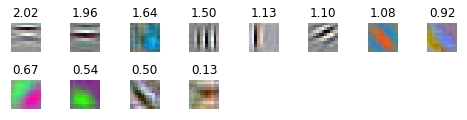

In [59]:
# This code just gets the importance scores of each filter
def calc_scores(best_ascat2, model2):
    scores = []
    for f_num in range(12):
    # for f_num in range(model.module.n_flayer - model.module.nfscat*3):
        best_ascat2 = copy.deepcopy(best_ascat['state_dict'])
        best_ascat2['module.features.0.weight'][f_num] = 0
        model2.load_state_dict(best_ascat2)
        losses, top1 = test(testloader, model2, criterion, True)
        scores.append(top1)
    scores = np.array(scores)
    return scores
scores = calc_scores(best_ascat2, model2)


#if not os.path.exists('../importance/j2l3'):
#    os.makedirs('../importance/j2l3')

def plot_filters(scores, model_weights):
    #This code goes through and plots each filter.
    num_cols = 8
    num_rows = 1 + len(scores)//num_cols
    fig = plt.figure(figsize=(num_cols, num_rows))
    for importance, f_num in enumerate(np.argsort(scores)):
        ax1 = fig.add_subplot(num_rows, num_cols, importance + 1)
        minned = model_weights[f_num] - np.min(model_weights[f_num])
        ax1.imshow(minned/np.max(minned))
        ax1.axis('off')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax1.set_title('{0:.2f}'.format(allFilters - scores[f_num]))
    plt.subplots_adjust(wspace=1.0, hspace=0.1)
    plt.savefig("TEST_SCHANNEL.png")
    plt.show()

# filter max activation

0
1
2
3
4
5
6
7
8
9
10
11


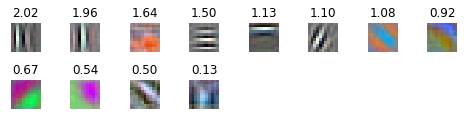

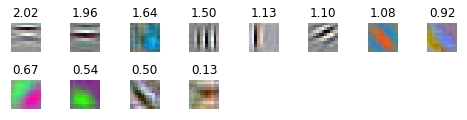

In [61]:
'''
Makes a noisy image and turns it into a torch array so we can later turn it into a variable and calculate gradients on it and apply them.
'''
def make_image(): 
    images = []
    for _ in range(3):
        image = np.random.randn(11,11)/5+0.5
        image = np.pad(image, ((11, 11), (11, 11)), 'constant')
        images.append(image)
    image = np.stack(images)
    image = image.transpose(0,2,1)
    
    torch_image = torch.from_numpy(image).float()
    torch_image = torch_image.unsqueeze_(0)
    return torch_image
    #im_as_var = Variable(torch_image.cuda(), requires_grad=True)

#This code applies the maximal activation for each filter and then plots the resulting image.

fig = plt.figure(figsize=(num_cols, num_rows))
REGULARIZATION = 0.0001
for idx, f_num in enumerate(np.argsort(scores)):
    print(idx)
    torch_image = make_image()
    im_as_var = Variable(torch_image.cuda(), requires_grad=True)
    optimizer = SGD([im_as_var], lr=12,  weight_decay=1e-4)
    for i in range(1, 501):
        optimizer.zero_grad()

        x = im_as_var
        x = model.module.features[0](x)
        #x = x.view(x.size(0), model.module.nfscat*3, model.module.nspace, model.module.nspace)
        loss = x[0, f_num, 4, 4]

        #https://towardsdatascience.com/pytorch-implementation-of-perceptual-losses-for-real-time-style-transfer-8d608e2e9902
#         reg_loss = REGULARIZATION * (
#         torch.sum(torch.abs(im_as_var[:, :, :-1] - im_as_var[ :, :, 1:])) + 
#         torch.sum(torch.abs(im_as_var[ :, :-1, :] - im_as_var[:, 1:, :]))
#         )
        reg_loss = 0


        loss = loss + reg_loss

        loss.backward()
        optimizer.step()

    recreated_im = copy.copy(im_as_var.data.cpu().numpy()[0]).transpose(1,2,0)
    recreated_im = recreated_im[11:22, 11:22, :]
    minned = recreated_im - np.min(recreated_im)
    ax1 = fig.add_subplot(num_rows, num_cols, idx + 1)
    ax1.imshow(minned/np.max(minned))
    ax1.axis('off')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_title('{0:.2f}'.format(allFilters - scores[f_num]))

plt.subplots_adjust(wspace=1.0, hspace=0.1)
plt.savefig("TEST_SCHANNEL.png")

plt.show()

plot_filters(scores, model_weights)
plt.show()

	#cv2.imwrite("../importance/j2l3/"+"i"+str(importance)+"a"+str(scores[f_num])+"f"+str(f_num)+"dream.jpg", fin*255)
	#minned = model_weights[f_num] - np.min(model_weights[f_num])
	#fin = minned/np.max(minned)
	#cv2.imwrite("../importance/j2l3/"+"i"+str(importance)+"a"+str(scores[f_num])+"f"+str(f_num)+"filter.jpg", fin*255)